In [ ]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm

#для использовния класса и методов надо в файлы колаб закинуть файл circle_generation.py с кодом
from circle_generation import GrayScaleDataProvider
from circle_generation import RgbDataProvider

#Посмотреть как генерируются и выглядят данные

In [ ]:
nx = 600 #размеры изображения
ny = 600

In [ ]:
gen2 = RgbDataProvider(nx, ny, cnt=10)

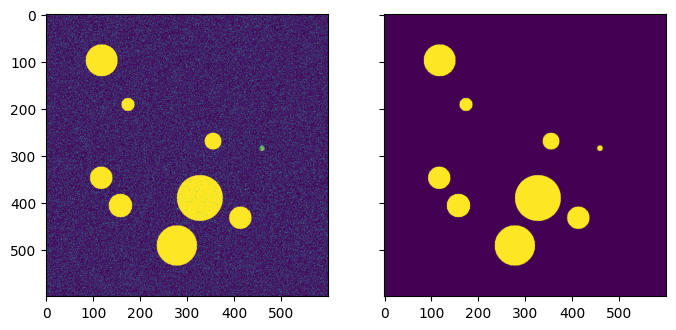

In [ ]:
x3_gen, y3_gen = gen2(1)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x3_gen[0,...,0])
ax[1].imshow(y3_gen[0,...,1])
plt.show()

In [ ]:
x3_gen.shape

(1, 600, 600, 3)

In [ ]:
y3_gen.shape

(1, 600, 600, 2)

#Генерация train данных

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #колаб не всегда позволят подключиться к cuda
device

'cuda'

In [ ]:
def circle_generator(num_imgs):
  """Функция генерации кружочков
  На вход:
  num_imgs - количество генерируемых кругов
  На выход:
  imgs - список массивов типа array с картинками
  (576, 576, 3) H x W x кол-во каналов
  maskes- список массивов типа array  масками
  (1, 576, 576) 1 батч х H x W (потом эту размерность перемещаю на последнее
  место и она будет кол-вом каналов)

  """
  #num_imgs = 10 #требуемое количество генерируемых картинок
  #print(f' num_imgs - {num_imgs}')
  imgs = [] #создаю пустой список для сохранения картинок
  masks = [] #создаю пустой список для сохранения масок
  for i in range(num_imgs):
    #print(i)
    cnt = random.randint(0,20) #генерируем случайное количество кругов на картинке (от 0 до 20)
    #generator = GrayScaleDataProvider(nx = 576, ny = 576, cnt=cnt) #инициализируем генератор

    generator = RgbDataProvider(nx = 576, ny = 576, cnt=cnt) #инициализируем генератор
    x_gen, y_gen = generator(1) #генерируем картинку и ее маску (1 батч)
    #форма x_gen - (кол-во батчей(1), высота изобр (576), ширина изобр(576), кол-во каналов(3))
    #форма y_gen - (кол-во батчей(1), высота изобр(576), ширина изобр (576), колво каналов, 1-й где фон - 0)
    x_gen = np.squeeze(x_gen, axis = 0) #удаляем первую ось, т.к. она нам не нужна
    #y_gen = np.squeeze(y_gen, axis = 0) #т.к. мы копируем только срез по 1 каналу, то эту ось потом перенесу в поз.2

    imgs.append(x_gen) #добавляем в список очередную картинку
    masks.append(y_gen[:,:,:,1]) #добавляем в список соответствующую маску
  return imgs, masks

In [ ]:
imgs, masks = circle_generator(10)

In [ ]:
len(imgs)

10

In [ ]:
x_gen.shape

(576, 576, 3)

In [ ]:
y_gen.shape

(1, 576, 576, 2)

In [ ]:
y_gen[:,:,:,1].shape

(1, 576, 576)

In [ ]:
masks[0].shape

(1, 576, 576)

In [ ]:
masks[0][0][1][0]

np.float64(0.0)

In [ ]:
imgs[0].shape

(576, 576, 3)

In [ ]:
class CircleDataset(torch.utils.data.Dataset):
  def __init__(self, imgs, masks):
    super().__init__()
    self.imgs = imgs
    self.masks = masks
    #сделала отдельный атрибут влруг потом нужно будет как-то изменять изображения
    #self.transforms = transforms.Compose([
        #transforms.ToTensor()])

  def __getitem__(self, item):
    #img = self.transforms(imgs[item]) #применяем преобразования к изображению с индексом item
    #mask = self.transforms(masks[item])
    #print(item)
    img = self.imgs[item]
    mask = self.masks[item]

    img = torch.tensor(img, dtype = torch.float32)
    mask = torch.tensor(mask, dtype = torch.float32)

    #print(img.shape)
    #print(mask.shape)

    img = img.permute(2,0,1).to(device) #переносим ось с количеством каналов с 2-1й оси на 0-ю (требование сети)
    #mask = mask.permute(1,2,0).to(device) #аналогично для масок
    mask = mask.to(device)

    #print(img.shape)
    #print(mask.shape)

    return img, mask

  def __len__(self):
    return len(self.imgs)   #магический метод для определения длины датасета

In [ ]:
circle_train = CircleDataset(imgs = imgs, masks = masks)

In [ ]:
circle_train[0][0].shape

torch.Size([3, 576, 576])

In [ ]:
#!mkdir train #создаю папку для сохранения картинок обучающего набора
#!mkdir masks #создаю папку для сохранения масок обучающего набора

#Создание модели UNet

In [ ]:
class UnetModel(nn.Module): #создаем 0класс модели UNet
  def __init__(self, in_channels = 3, num_classes = 1): #изображение с 3 каналом, класс - 1, т.к. все круги считаем одинаковыми
    super().__init__()
    #дальше кол-во каналов и слои расположены в соответствии с архитектурой Unet
    self.enc_block1 = self._EncoderBlock(in_channels, 64)
    self.enc_block2 = self._EncoderBlock(64, 128)
    self.enc_block3 = self._EncoderBlock(128, 256)
    self.enc_block4 = self._EncoderBlock(256, 512)

    self.bottleneck = self._TwoConvLayers(512, 1024)

    self.dec_block1 = self._DecoderBlock(1024, 512)
    self.dec_block2 = self._DecoderBlock(512, 256)
    self.dec_block3 = self._DecoderBlock(256, 128)
    self.dec_block4 = self._DecoderBlock(128, 64)

    self.out = nn.Conv2d(64, num_classes, 1) #свертка 1х1 и требуемым количеством классов

  def forward(self, x):
    #print('Энкодер 1')
    x, y1 = self.enc_block1(x)
    #print('Энкодер 2')
    x, y2 = self.enc_block2(x)
    #print('Энкодер 3')
    x, y3 = self.enc_block3(x)
    #print('Энкодер 4')
    x, y4 = self.enc_block4(x)

    #print('Боттленек')
    x = self.bottleneck(x)

    #print('Декодер 1')
    x = self.dec_block1(x, y4)
    #print('Декодер 2')
    x = self.dec_block2(x, y3)
    #print('Декодер 3')
    x = self.dec_block3(x, y2)
    #print('Декодер 4')
    x = self.dec_block4(x, y1)

    return self.out(x)

  class _TwoConvLayers(nn.Module): #создаем подкласс с 2-мя подряд сверточными слоями
    def __init__(self, in_channels, out_channels):
      super().__init__() #вызов инициализатора базового класса UnetModel
      self.model = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding = 1, bias = False), #свертка 3х3 с padd
          nn.ReLU(inplace = True), #ф-ция активации 1-й светки
          nn.Conv2d(out_channels, out_channels, 3, padding = 1, bias = False),
          nn.ReLU(inplace = True),
          nn.BatchNorm2d(out_channels)
      )
    def forward(self, x):
      return self.model(x)

  class _EncoderBlock(nn.Module): #задаем класс кодировщика
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.block = UnetModel._TwoConvLayers(in_channels, out_channels)
      self.max_pool = nn.MaxPool2d(2) #слой MaxPoolинга 2х2, шаг тоже 2

    def forward(self, x):
      #print(f'x до сверток: {x.shape}')
      x = self.block(x) #пропускаем изображение через 2 свертки с ReLU и Batcnorm
      #пропускаем изобр через max_pool, х потом пойдет в контакенацию с выходом декодера,
      # у- на следующие слои энкодера
      #print(f'x после сверток: {x.shape}')
      y = self.max_pool(x)
      #print(f'у после max pool: {x.shape}')
      return y, x

  class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.transpose = nn.ConvTranspose2d(in_channels, out_channels, 2, stride = 2) #расширение в 2 раза с  шаком 2
      self.block = UnetModel._TwoConvLayers(in_channels, out_channels)

    def forward(self, x, y):
      #print(f'x до развертки: {x.shape}')
      #print(f'у до развертки: {x.shape}')
      x = self.transpose(x) #пропускаем изображение через ConvTranspose2d
      #print(f'x после развертки= {x.shape}')
      u = torch.cat([x , y], dim = 1) #конкатенируем с х с ссотв.слоя энкодера по каналам
      u = self.block(u) #пропускаем через 2 слоя сверток
      return u



#Подготовка к обучению

In [ ]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets): #logits - предсказание масок моделью, targets - истинные маски
        num = targets.size(0) #берем количество изображений в батче из целевого тензора (по требовнаию сети кол-во батчей на первом месте)
        #после последнего слоя сети нет ф-ции активации, нам нужны вероятности принадлежности пикселя к классу
        #поэтому сигмоида к предсказаниям модели
        probs = nn.functional.sigmoid(logits)
        m1 = probs.view(num, -1) #вытягиваем тензор по батчам (кол-во строк - кол-во батчей, кол-во столбцов вычисляется автоматически)
        m2 = targets.view(num, -1)
        #умножаем предсказанные маски на истинные. Т.к. истинные маски- 0 и 1, то там где не угадали будет 0
        #и выделятся только пиксели пересечения
        intersection = (m1 * m2)

        #при суммировании предсказанных  и истинных значений будут суммироваться пиксели объекта
        #т.е. в итоге, чем точнее предсказаи объект, тем меньше loss
        #smooth - добавлен для исключения вероятности деления на 0
        score = 2 * (intersection.sum(1) + self.smooth) / (m1.sum(1) + m2.sum(1) + self.smooth)
        score = 1 - score.sum() / num #делим на кол-во изображений в батче чтобы получить ошибку на 1 картинку
        return score

In [ ]:
batch_size = 2

In [ ]:
train_data = torch.utils.data.DataLoader(circle_train, batch_size = batch_size, shuffle = True)

In [ ]:
model = UnetModel().to(device)

In [ ]:
epochs = 10

In [ ]:
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=0.001)
loss_1 = nn.BCEWithLogitsLoss()
loss_2 = SoftDiceLoss()


In [ ]:
"""
for X, y in train_data:
  print(X.shape)
  print(y.shape)
  pred = model(X)
  break

torch.Size([1, 3, 576, 576])
torch.Size([1, 1, 576, 576])


In [ ]:
"""pred.shape

torch.Size([1, 1, 576, 576])

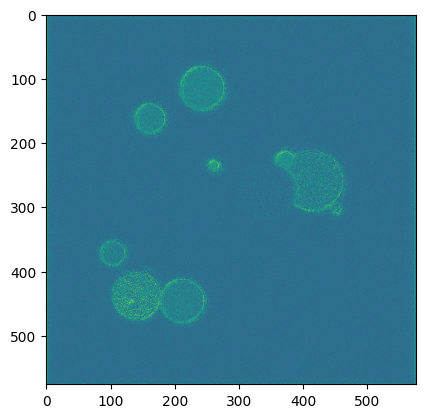

In [ ]:
#plt.imshow(pred[0,0,:,:].detach().numpy())
#plt.show()

#Обучение

In [ ]:
model.train()

UnetModel(
  (enc_block1): _EncoderBlock(
    (block): _TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): ReLU(inplace=True)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_block2): _EncoderBlock(
    (block): _TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): ReLU(inplace=True)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (max_po

In [ ]:
for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_1(predict, y_train.float()) + loss_2(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        #ф-ция потерь складывается из двух функций loss_1 и loss2,
        #т.е., минимизируется бинарная кросс-энтропия и максимизируется коэффициент dice
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

Epoch [10/10], loss_mean=1.408: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


#Предсказание

In [ ]:
#переводим модель в режим педсказания
model.eval()

UnetModel(
  (enc_block1): _EncoderBlock(
    (block): _TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): ReLU(inplace=True)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_block2): _EncoderBlock(
    (block): _TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): ReLU(inplace=True)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (max_po

In [ ]:
n_test = 2 #количество тестовых картинок

In [ ]:
#генерируем 2 новых тестовых картинки
imgs_test, masks_test = circle_generator(2)

In [ ]:
circle_test = CircleDataset(imgs = imgs_test, masks = masks_test)

Слева истинная картинка, справа предсказанная маска


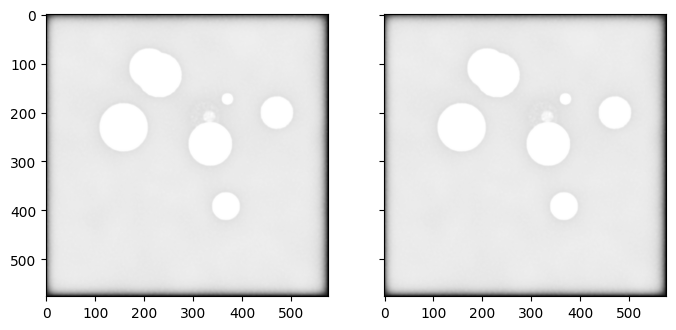

Слева истинная картинка, справа предсказанная маска


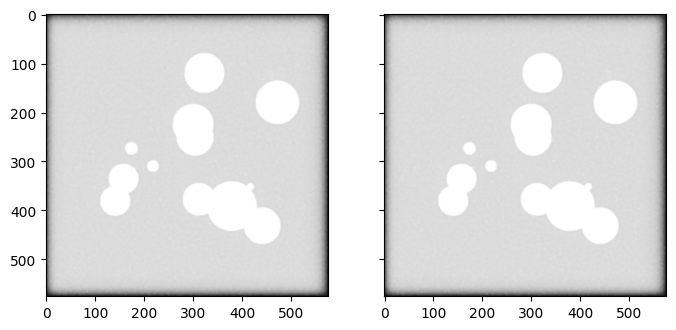

In [ ]:
for i in range (n_test):
  #в картинку добавим размерность батча чтобы в модель передавались данные одинаковых размерностей
  img_test = circle_test[i][0].unsqueeze(0)
  p = model(img_test) #получаем предсказание модели
  p = p.squeeze(0) #удаляем размерность батча из предсказания
  p = p.permute(1, 2, 0) #смещаем канал на 2-ю позицию как требует plt
  #т.к. в модели после выходного слоя нет ф-ции активации, а нам надо получить вероятность отношение
  #к классу, то ставим сигмоиду после предсказания
  y = nn.functional.sigmoid(p)
  y = y.detach().cpu().numpy() * 255  #переводим в numpy и *255 чтобы получить значения пикселей как у картинок
  y = np.clip(y, 0, 255).astype('uint8') #оставляем значения 0-255 как у картинок

  x_fact = circle_test[i][0].permute(1, 2, 0)
  x_fact = x_fact.cpu().numpy() * 255
  x_fact = np.clip(y, 0, 255).astype('uint8')

  print('Слева истинная картинка, справа предсказанная маска')
  fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
  ax[0].imshow(x_fact, cmap='gray')
  ax[1].imshow(y, cmap='gray')
  plt.show()